# Imports and constants

In [49]:
import pandas as pd
import numpy as np

import librosa

import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt


from pathlib import Path

from sklearn.preprocessing import normalize

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D


In [50]:
DURATION = 25
SAMPLING_RATE = 22050
BATCH_SIZE = 16


# Loading csv

In [104]:
def load_csv(path):
    data_csv = pd.read_csv(path, skipinitialspace=True)
    labels = data_csv.drop(
        columns=["mood", "age", "gender", "disliked",
                 "liked", "mother tongue", "genre"]
    )  # unnecessary columns
    labels = labels.groupby("track id").mean()
    for column in labels.columns:
        labels[column] = labels[column].apply(lambda x: 1 if (x >= 0.5) else 0)

    return labels


y = load_csv("data.csv")
y

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness
track id,,,,,,,,,
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
396,0,0,0,1,0,0,0,0,0
397,0,0,0,0,0,0,0,0,1
398,0,0,0,0,0,0,1,0,0


# Loading audio

## Loading files names

In [52]:
def audio_paths():
    file_paths = []
    audio_path = Path("audio")
    genres = audio_path.glob("*")
    for genre in genres:
        for i in range(1, 101, 1):
            path = Path(f"{genre}/{i}.mp3")
            file_paths.append(str(path))
    return file_paths


files = audio_paths()
for i in files:
    print(i)
    break


audio\classical\1.mp3


## Loading data from files

In [53]:
def load_audio_file(file_path, offset=0):
    print(f"Loading: {file_path}")
    data, _ = librosa.load(
        path=file_path, sr=SAMPLING_RATE, duration=DURATION, offset=offset
    )
    return data

In [54]:
audio = [load_audio_file(file) for file in files]


Loading: audio\classical\1.mp3
Loading: audio\classical\2.mp3
Loading: audio\classical\3.mp3
Loading: audio\classical\4.mp3
Loading: audio\classical\5.mp3
Loading: audio\classical\6.mp3
Loading: audio\classical\7.mp3
Loading: audio\classical\8.mp3
Loading: audio\classical\9.mp3
Loading: audio\classical\10.mp3
Loading: audio\classical\11.mp3
Loading: audio\classical\12.mp3
Loading: audio\classical\13.mp3
Loading: audio\classical\14.mp3
Loading: audio\classical\15.mp3
Loading: audio\classical\16.mp3
Loading: audio\classical\17.mp3
Loading: audio\classical\18.mp3
Loading: audio\classical\19.mp3
Loading: audio\classical\20.mp3
Loading: audio\classical\21.mp3
Loading: audio\classical\22.mp3
Loading: audio\classical\23.mp3
Loading: audio\classical\24.mp3
Loading: audio\classical\25.mp3
Loading: audio\classical\26.mp3
Loading: audio\classical\27.mp3
Loading: audio\classical\28.mp3
Loading: audio\classical\29.mp3
Loading: audio\classical\30.mp3
Loading: audio\classical\31.mp3
Loading: audio\cl

In [55]:
ipd.Audio(audio[3], rate=SAMPLING_RATE)


# Features extraction

## Padding

In [56]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode="constant")


## Spectrogram 

In [57]:
def get_abs_spectrogram(raw_audio):
    return np.abs(librosa.stft(y=raw_audio, n_fft=255, hop_length=512))


## MFCCs

In [58]:
def get_mfccs(raw_audio):
    return librosa.feature.mfcc(y=raw_audio, n_fft=255, hop_length=512, n_mfcc=128)

## Spectral centroid

In [59]:
def get_centroid(raw_audio):
    return librosa.feature.spectral_centroid(y=raw_audio, sr=SAMPLING_RATE)

## Chromatic stft

In [60]:
def get_chroma(raw_audio):
    return librosa.feature.chroma_stft(y=raw_audio, sr=SAMPLING_RATE)

## Spectral bandwidth

In [61]:
def get_bandwidth(raw_audio):
    return librosa.feature.spectral_bandwidth(y=raw_audio, sr=SAMPLING_RATE)


## Shapes

In [62]:
a = audio[3]
spec = get_abs_spectrogram(a)
mfccs = get_mfccs(a)
centroid = get_centroid(a)
chroma = get_chroma(a)
bandwidth = get_bandwidth(a)
print(f"spectrogram: {spec.shape}")
print(f"mfccs: {mfccs.shape}")
print(f"spec_centroid: {centroid.shape}")
print(f"chroma_stft: {chroma.shape}")
print(f"spec_bandwidth: {bandwidth.shape}")


spectrogram: (128, 1077)
mfccs: (128, 1077)
spec_centroid: (1, 1077)
chroma_stft: (12, 1077)
spec_bandwidth: (1, 1077)


# Visualizing sample

In [63]:
y.iloc[3]


amazement            0
solemnity            0
tenderness           1
nostalgia            1
calmness             1
power                0
joyful_activation    0
tension              0
sadness              0
Name: 4, dtype: int64

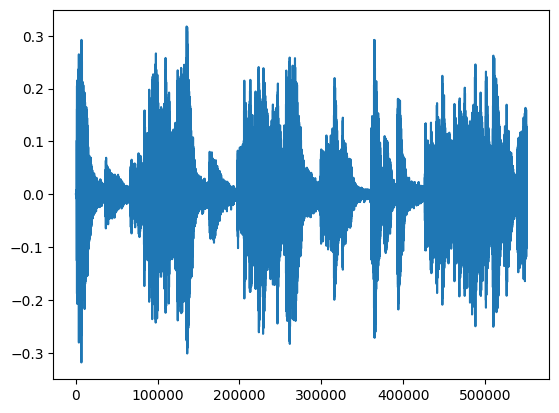

In [64]:
plt.plot(audio[3])


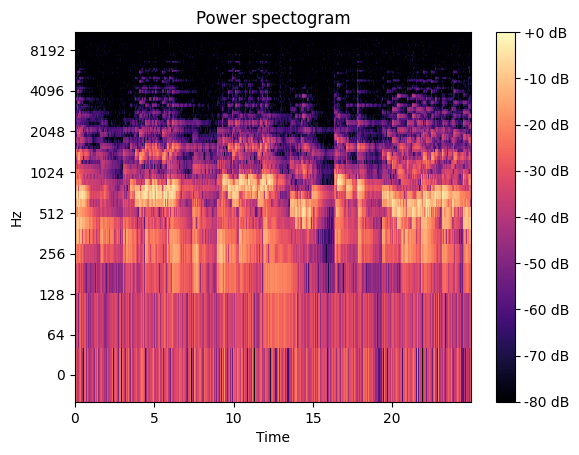

In [65]:
def show_spectrogram(spec):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(
        librosa.amplitude_to_db(spec, ref=np.max), y_axis="log", x_axis="time", ax=ax
    )
    ax.set_title("Power spectogram")
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
show_spectrogram(spec)

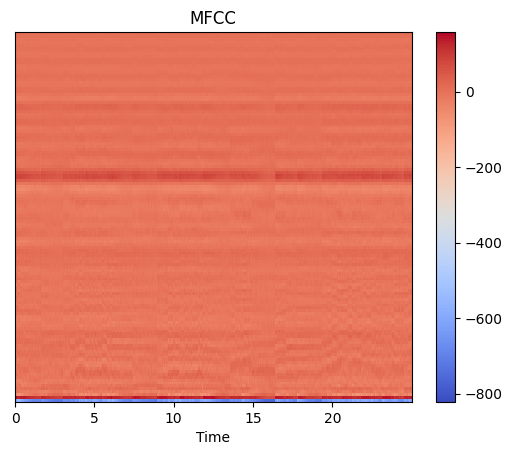

In [66]:
def show_mffcs(mffcs):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mffcs, x_axis="time", ax=ax)
    ax.set_title("MFCC")
    fig.colorbar(img, ax=ax)
show_mffcs(mfccs)

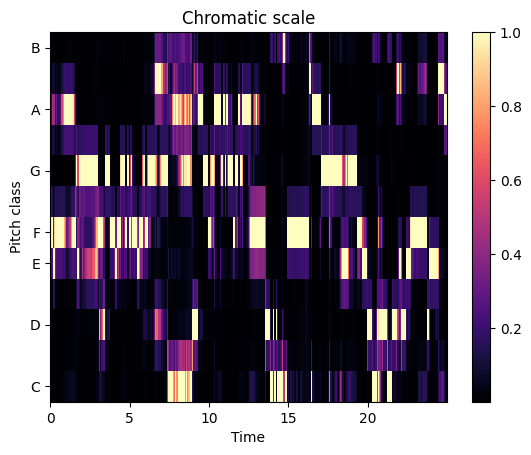

In [67]:
def show_chroma(chroma):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(
    chroma, y_axis='chroma', x_axis='time', ax=ax)
    ax.set_title("Chromatic scale")
    fig.colorbar(img, ax=ax)
show_chroma(chroma)

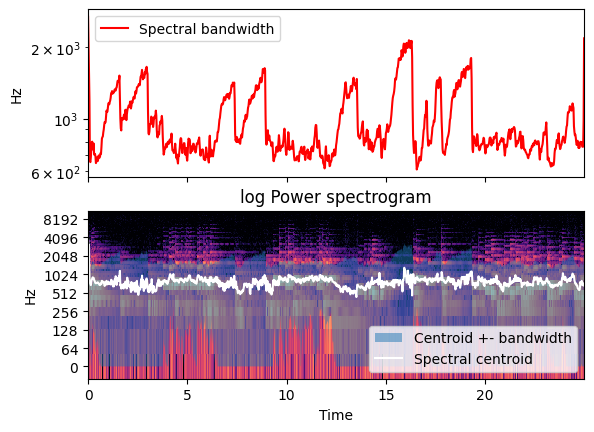

In [68]:
def show_bandwidth(bandwidth, sr, centroid, spec):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    times = librosa.times_like(bandwidth)
    centroid = librosa.feature.spectral_centroid(S=spec)
    ax[0].semilogy(times, bandwidth[0], label='Spectral bandwidth', c='r')
    ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
    ax[0].legend()
    ax[0].label_outer()
    librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max),
                            y_axis='log', x_axis='time', ax=ax[1])
    ax[1].set(title='log Power spectrogram')
    ax[1].fill_between(times, np.maximum(0, centroid[0] - bandwidth[0]),
                    np.minimum(centroid[0] + bandwidth[0], sr/2),
                    alpha=0.5, label='Centroid +- bandwidth')
    ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
    ax[1].legend(loc='lower right')
show_bandwidth(bandwidth, SAMPLING_RATE, centroid, spec)

# Preparing tf dataset

In [121]:
def get_features(audio):
    max_size = 1100
    # 1st channel
    spec = padding(get_abs_spectrogram(audio), 128, max_size)
    # 2nd channel
    mfccs = padding(get_mfccs(audio),128, max_size)
    # 3rd channel
    centroid = get_centroid(audio)
    chroma = get_chroma(audio)
    bandwidth = get_bandwidth(audio)
    
    img = np.array([padding(normalize(bandwidth), 1, max_size)]).reshape(1,max_size)
    img = np.append(img, padding(normalize(centroid), 1, max_size), axis=0)
    
    for i in range(9):
        img = np.append(img, padding(normalize(bandwidth), 1 ,max_size), axis=0)
        img = np.append(img, padding(normalize(centroid), 1 ,max_size), axis=0)
        img = np.append(img, padding(normalize(chroma), 1 ,max_size), axis=0)
    img = np.dstack((img, spec))
    img = np.dstack((img, mfccs))
    
    return img

In [122]:
import warnings
warnings.filterwarnings("ignore")
X = [get_features(a) for a in audio]

In [123]:
X[0].shape

(128, 1100, 3)

In [72]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [73]:
dataset


<TensorSliceDataset element_spec=(TensorSpec(shape=(128, 1100, 3), dtype=tf.float64, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>

In [74]:
data = dataset.cache()
data = data.shuffle(buffer_size=1000)
train = data.take(350).batch(BATCH_SIZE)
test = data.skip(350).take(50).batch(BATCH_SIZE)



In [75]:
len(train), len(test)

(22, 4)

In [76]:
samples, labels = data.as_numpy_iterator().next()


In [77]:
samples.shape


(128, 1100, 3)

# CNN model 

In [79]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 1100, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.35))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(9, activation="sigmoid"))

In [80]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


In [81]:
history = model.fit(train, epochs=10, verbose=1, validation_data=test)

Epoch 1/10
22/22 [==============================] - 3s 98ms/step - loss: 2.0026 - binary_accuracy: 0.5895 - val_loss: 0.6123 - val_binary_accuracy: 0.6778
Epoch 2/10
22/22 [==============================] - 2s 80ms/step - loss: 0.6518 - binary_accuracy: 0.6606 - val_loss: 0.6282 - val_binary_accuracy: 0.7578
Epoch 3/10
22/22 [==============================] - 2s 79ms/step - loss: 0.6304 - binary_accuracy: 0.6752 - val_loss: 0.5971 - val_binary_accuracy: 0.7244
Epoch 4/10
22/22 [==============================] - 2s 78ms/step - loss: 0.6148 - binary_accuracy: 0.6803 - val_loss: 0.5865 - val_binary_accuracy: 0.7067
Epoch 5/10
22/22 [==============================] - 2s 78ms/step - loss: 0.5999 - binary_accuracy: 0.7025 - val_loss: 0.5564 - val_binary_accuracy: 0.7178
Epoch 6/10
22/22 [==============================] - 2s 78ms/step - loss: 0.5975 - binary_accuracy: 0.7016 - val_loss: 0.5788 - val_binary_accuracy: 0.7022
Epoch 7/10
22/22 [==============================] - 2s 78ms/step - los

In [96]:
a = load_audio_file("I Doubted.mp3", offset=10)
f = get_features(a)
s = tf.convert_to_tensor(f)
s = tf.expand_dims(s, 0)

r = model.predict(t)

Loading: I Doubted.mp3
1/1 [==============================] - 0s 37ms/step


In [103]:
r[0]

array([0.19765715, 0.30086383, 0.32636705, 0.4492037 , 0.50548124,
       0.31210667, 0.4070842 , 0.35077637, 0.30504447], dtype=float32)

# RNN model 